# <span style="color: #034f84">Imports</span>

In [1]:
import pandas as pd
import numpy as np
from rectools import Columns
from rectools.dataset import Dataset, Interactions
from rectools.metrics import MAP, calc_metrics
from hyperopt import hp, fmin, tpe, STATUS_OK

from models import PopularInUserCategory

import warnings
warnings.filterwarnings('ignore')

# <span style="color: #034f84">Load Data</span>

In [2]:
interactions = pd.read_csv('data/interactions_processed.csv',  parse_dates=['last_watch_dt'])
interactions.rename(
    columns={
        'last_watch_dt': Columns.Datetime,
        'total_dur': Columns.Weight
    },
    inplace=True
)
interactions.head(5)

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72
1,699317,1659,2021-05-29,8317,100
2,656683,7107,2021-05-09,10,0
3,864613,7638,2021-07-05,14483,100
4,964868,9506,2021-04-30,6725,100


In [3]:
items = pd.read_csv('data/items_processed.csv')
items = items[items[Columns.Item].isin(interactions[Columns.Item])]
print(f"Items shape: {items.shape}")
items.head(5)

Items shape: (15706, 14)


,item_id,content_type,title,title_orig,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,release_year_cat
0,10711,film,поговори с ней,Hable con ella,"драмы, зарубежные, детективы, мелодрамы",испания,False,16.0,unknown,педро альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ...",2000-2010
1,2508,film,голые перцы,Search Party,"зарубежные, приключения, комедии",сша,False,16.0,unknown,скот армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео...",2010-2020
2,10716,film,тактическая сила,Tactical Force,"криминал, зарубежные, триллеры, боевики, комедии",канада,False,16.0,unknown,адам п. калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг...",2010-2020
3,7868,film,45 лет,45 Years,"драмы, зарубежные, мелодрамы",великобритания,False,16.0,unknown,эндрю хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю...",2010-2020
4,16268,film,все решает мгновение,None,"драмы, спорт, советские, мелодрамы",ссср,False,12.0,ленфильм,виктор садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж...",1970-1980


In [4]:
users = pd.read_csv('data/users_processed.csv')
print(f"Users shape: {users.shape}")
users.head()

Users shape: (840197, 5)


,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,M,True
1,962099,age_18_24,income_20_40,M,False
2,1047345,age_45_54,income_40_60,F,False
3,721985,age_45_54,income_20_40,F,False
4,704055,age_35_44,income_60_90,F,False


In [5]:
submission = pd.read_csv('data/sample_submission.csv')

# <span style="color: #034f84">Some Header</span>

In [6]:
last_date = interactions['datetime'].max().normalize()
thd_dttm = last_date - pd.Timedelta(days=7)

train = interactions[interactions[Columns.Datetime] < thd_dttm]
test = interactions[interactions[Columns.Datetime] >= thd_dttm]

print(f"Train size: {train.shape[0]}")
print(f"Test size: {test.shape[0]}")

Train size: 4985269
Test size: 490982


# <span style="color: #034f84">User Features Preparation</span>

In [7]:
fillna_vals = {col: col + "_unknown" for col in users.columns}
fillna_vals

{'user_id': 'user_id_unknown',
 'age': 'age_unknown',
 'income': 'income_unknown',
 'sex': 'sex_unknown',
 'kids_flg': 'kids_flg_unknown'}

In [8]:
users.fillna(fillna_vals, inplace=True)

In [9]:
users = users.loc[users[Columns.User].isin(train[Columns.User])]
users.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,M,True
1,962099,age_18_24,income_20_40,M,False
3,721985,age_45_54,income_20_40,F,False
4,704055,age_35_44,income_60_90,F,False
5,1037719,age_45_54,income_60_90,M,False


In [10]:
user_features = []
for feature in ["sex", "age", "income"]:
    feature_tmp = users.reindex(columns=[Columns.User, feature])
    feature_tmp.columns = ["id", "value"]
    feature_tmp["feature"] = feature
    user_features.append(feature_tmp)
user_features = pd.concat(user_features)
user_features.head()

,id,value,feature
0,973171,M,sex
1,962099,M,sex
3,721985,F,sex
4,704055,F,sex
5,1037719,M,sex


# <span style="color: #034f84">Item Features Preparation</span>

In [11]:
items = items.loc[items[Columns.Item].isin(train[Columns.Item])]
items.head()

,item_id,content_type,title,title_orig,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,release_year_cat
0,10711,film,поговори с ней,Hable con ella,"драмы, зарубежные, детективы, мелодрамы",испания,False,16.0,unknown,педро альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ...",2000-2010
1,2508,film,голые перцы,Search Party,"зарубежные, приключения, комедии",сша,False,16.0,unknown,скот армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео...",2010-2020
2,10716,film,тактическая сила,Tactical Force,"криминал, зарубежные, триллеры, боевики, комедии",канада,False,16.0,unknown,адам п. калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг...",2010-2020
3,7868,film,45 лет,45 Years,"драмы, зарубежные, мелодрамы",великобритания,False,16.0,unknown,эндрю хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю...",2010-2020
4,16268,film,все решает мгновение,None,"драмы, спорт, советские, мелодрамы",ссср,False,12.0,ленфильм,виктор садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж...",1970-1980


### <span style="color: #405d27">Genre Feature</span>

In [12]:
items["genre"] = items["genres"].str.split(",")
genre_feature = items[["item_id", "genre"]].explode("genre")
genre_feature.columns = ["id", "value"]
genre_feature["feature"] = "genre"
genre_feature.head()

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre


### <span style="color: #405d27">Content Type Feature</span>

In [13]:
content_feature = items.reindex(columns=[Columns.Item, "content_type"])
content_feature.columns = ["id", "value"]
content_feature["feature"] = "content_type"
content_feature.head()

,id,value,feature
0,10711,film,content_type
1,2508,film,content_type
2,10716,film,content_type
3,7868,film,content_type
4,16268,film,content_type


### <span style="color: #405d27">Release Year Feature</span>

In [14]:
ryear_feature = items.reindex(columns=[Columns.Item, "release_year_cat"])
ryear_feature.columns = ["id", "value"]
ryear_feature["feature"] = "release_year_cat"
ryear_feature.head()

,id,value,feature
0,10711,2000-2010,release_year_cat
1,2508,2010-2020,release_year_cat
2,10716,2010-2020,release_year_cat
3,7868,2010-2020,release_year_cat
4,16268,1970-1980,release_year_cat


In [15]:
item_features = pd.concat(
    (genre_feature, content_feature, ryear_feature)
)

In [16]:
dataset = Dataset.construct(
    interactions_df=train,
    user_features_df=user_features,
    cat_user_features=["sex", "age", "income"],
    item_features_df=item_features,
    cat_item_features=["genre", 'release_year_cat', 'content_type'],
)

# <span style="color: #034f84">LightFM</span>

In [17]:
from __future__ import annotations
from rectools.models import LightFMWrapperModel
from lightfm import LightFM

In [18]:
class MyLightFM:
    def __init__(
        self,
        no_components: int = 32,
        loss: str = 'warp',
        lr: float = 0.05,
        user_alpha: float = 0.05,
        item_alpha: float = 0.05,
        rnd_seed: int = 42
    ) -> None:
        self.no_components = no_components
        self.loss = loss
        self.lr = lr
        self.user_alpha = user_alpha
        self.item_alpha = item_alpha
        self.model = self._get_model()
    
    def _get_model(self) -> LightFMWrapperModel:
        lfm = LightFM(
            no_components=self.no_components,
            loss=self.loss,
            learning_rate=self.lr,
            user_alpha=self.user_alpha,
            item_alpha=self.item_alpha
        )
        return LightFMWrapperModel(model=lfm, epochs=2, num_threads=3)
    
    def fit(self, dataset: Dataset) -> MyLightFM:
        self.model.fit(dataset)
        return self
    
    def recommend(self, users: pd.DataFrame, dataset: Dataset):
        recs = self.model.recommend(
            users=users,
            dataset=dataset,
            filter_viewed=True,
            k=10
        )
        return recs

In [19]:
cold_users = set(test[Columns.User]) - set(train[Columns.User])
test.drop(test[test[Columns.User].isin(cold_users)].index, inplace=True)

test_users = test[Columns.User].unique()
metrics = {
    "map@10": MAP(k=10)
}

def lightfm_objective(params):
    model = MyLightFM(**params)
    model.fit(dataset)
    recs = model.recommend(test_users, dataset)
    metric_values = calc_metrics(metrics, recs, test, train)
    return {'loss': 1.0 / metric_values['map@10'], 'status': STATUS_OK}

lightfm_space = {
    "no_components": hp.choice("no_components", [4, 8, 12, 16]),
    "loss": 'warp',
    "lr": hp.uniform('lr', 0.01, 0.05),
    "user_alpha": hp.uniform('user_alpha', 0.0, 1.0),
    "item_alpha": hp.uniform('item_alpha', 0.0, 1.0),
    
}
best_lightfm = fmin(
    fn=lightfm_objective,
    space=lightfm_space,
    algo=tpe.suggest,
    max_evals=5,
    rstate=np.random.default_rng(42)
)
best_lightfm

100%|█████████████████████████████████████████████| 5/5 [04:00<00:00, 48.10s/trial, best loss: 12.698688225954111]


{'item_alpha': 0.15717970056189712,
 'lr': 0.034706434050920124,
 'no_components': 1,
 'user_alpha': 0.14696278728502776}

In [20]:
best_lightfm['no_components'] = [4, 8, 12, 16][best_lightfm['no_components']]
best_lightfm

{'item_alpha': 0.15717970056189712,
 'lr': 0.034706434050920124,
 'no_components': 8,
 'user_alpha': 0.14696278728502776}

In [27]:
1/12.698688225954111

0.0787482913358057

# <span style="color: #034f84">Submission</span>


In [21]:
recs = pd.DataFrame({'user_id': submission['user_id'].unique()})
cold_users = recs[~recs['user_id'].isin(dataset.user_id_map.external_ids)]
warm_users = recs[recs['user_id'].isin(dataset.user_id_map.external_ids)]

In [22]:
mylfm = MyLightFM(**best_lightfm)
mylfm.fit(dataset)
recs = (
    mylfm
    .recommend(
        users=warm_users[Columns.User].values,
        dataset=dataset
    )
    .drop(['score', 'rank'], axis=1)
    .groupby(Columns.User)
    .agg({Columns.Item: list})
    .reset_index()
)
recs.head()

,user_id,item_id
0,3,"[15297, 13865, 7829, 7571, 8636, 12995, 849, 1..."
1,11,"[10440, 13865, 9728, 4151, 2657, 3734, 7829, 4..."
2,30,"[10440, 15297, 13865, 4151, 2657, 3734, 7829, ..."
3,46,"[15297, 13865, 9728, 4151, 2657, 3734, 7829, 7..."
4,47,"[10440, 15297, 9728, 4151, 2657, 3734, 7829, 4..."


# <span style="color: #034f84">Popular Covered 60% Users for cold users (HW1)</span>

In [23]:
cols_recs_vals = [10440, 15297, 9728, 13865, 2657, 4151, 3734, 6809, 4740, 4880]
cold_recs = [cols_recs_vals for _ in range(cold_users.shape[0])]
cold_recs = pd.DataFrame(
    list(zip(cold_users['user_id'].values.tolist(), cold_recs)),
    columns=[Columns.User, Columns.Item])
cold_recs.head()

,user_id,item_id
0,29,"[10440, 15297, 9728, 13865, 2657, 4151, 3734, ..."
1,33,"[10440, 15297, 9728, 13865, 2657, 4151, 3734, ..."
2,39,"[10440, 15297, 9728, 13865, 2657, 4151, 3734, ..."
3,70,"[10440, 15297, 9728, 13865, 2657, 4151, 3734, ..."
4,74,"[10440, 15297, 9728, 13865, 2657, 4151, 3734, ..."


In [24]:
recs = pd.concat((cold_recs, recs))

In [36]:
recs.to_csv('submissions/lightfm.csv', index=False)
# offline Score = 0.0787482913358057

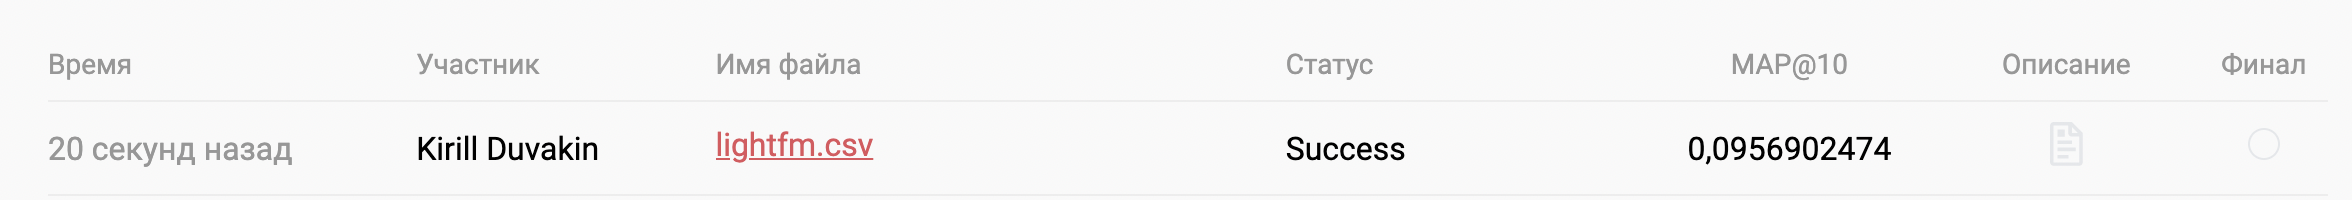

# <span style="color: #034f84">ImplicitALS</span>

In [29]:
from rectools.models import ImplicitALSWrapperModel
from implicit.als import AlternatingLeastSquares

In [31]:
class MyImplicitALS:
    def __init__(self, factors: int = 6, regularization: float = 0.05):
        self.factors = factors
        self.regularization = regularization
        self.model = self._get_model()
    
    def _get_model(self) -> ImplicitALSWrapperModel:
        als = AlternatingLeastSquares(
            factors=self.factors, 
            regularization=self.regularization,
            random_state=42,
            num_threads=2
        )
        return ImplicitALSWrapperModel(model=als, fit_features_together=True)
    
    def fit(self, dataset: Dataset) -> MyImplicitALS:
        self.model.fit(dataset)
        return self
    
    def recommend(self, users: pd.DataFrame, dataset: Dataset):
        recs = self.model.recommend(
            users=users,
            dataset=dataset,
            k=10,
            filter_viewed=True
        )
        return recs

In [32]:
def implicit_als_objective(params):
    model = MyImplicitALS(**params)
    model.fit(dataset)
    recs = model.recommend(test_users, dataset)
    metric_values = calc_metrics(metrics, recs, test, train)
    return {'loss': 1.0 / metric_values['map@10'], 'status': STATUS_OK}

implicit_als_space = {
    "factors": hp.choice("factors", [4, 8, 12, 16]),
    "regularization": hp.uniform('regularization', 0.0, 1.0)
}
best_implicit_als = fmin(
    fn=implicit_als_objective,
    space=implicit_als_space,
    algo=tpe.suggest,
    max_evals=3,
    rstate=np.random.default_rng(42)
)
best_implicit_als

100%|███████████████████████████████████████████| 3/3 [1:00:56<00:00, 1218.98s/trial, best loss: 74.5309159168737]


{'factors': 2, 'regularization': 0.8136554076402878}

In [33]:
best_implicit_als['factors'] = [4, 8, 12, 16][best_implicit_als['factors']]

In [34]:
best_implicit_als

{'factors': 12, 'regularization': 0.8136554076402878}

# <span style="color: #034f84">Submission</span>


In [35]:
recs = pd.DataFrame({'user_id': submission['user_id'].unique()})
cold_users = recs[~recs['user_id'].isin(dataset.user_id_map.external_ids)]
warm_users = recs[recs['user_id'].isin(dataset.user_id_map.external_ids)]

In [36]:
my_implicit_als = MyImplicitALS(**best_implicit_als)
my_implicit_als.fit(dataset)
recs = (
    my_implicit_als
    .recommend(
        users=warm_users[Columns.User].values,
        dataset=dataset
    )
    .drop(['score', 'rank'], axis=1)
    .groupby(Columns.User)
    .agg({Columns.Item: list})
    .reset_index()
)
recs.head()

,user_id,item_id
0,3,"[6071, 5, 6900, 6162, 1641, 14572, 11060, 6626..."
1,11,"[14470, 1399, 12463, 9070, 4716, 11778, 12501,..."
2,30,"[14431, 5958, 14814, 8584, 5838, 8373, 14399, ..."
3,46,"[13077, 7829, 12770, 4457, 2680, 5711, 15517, ..."
4,47,"[85, 6741, 973, 3808, 3628, 6214, 2677, 1916, ..."


In [37]:
recs = pd.concat((cold_recs, recs))

In [39]:
recs.to_csv('submissions/implicit_als.csv', index=False)
# offline Score = 0.013417250917932184

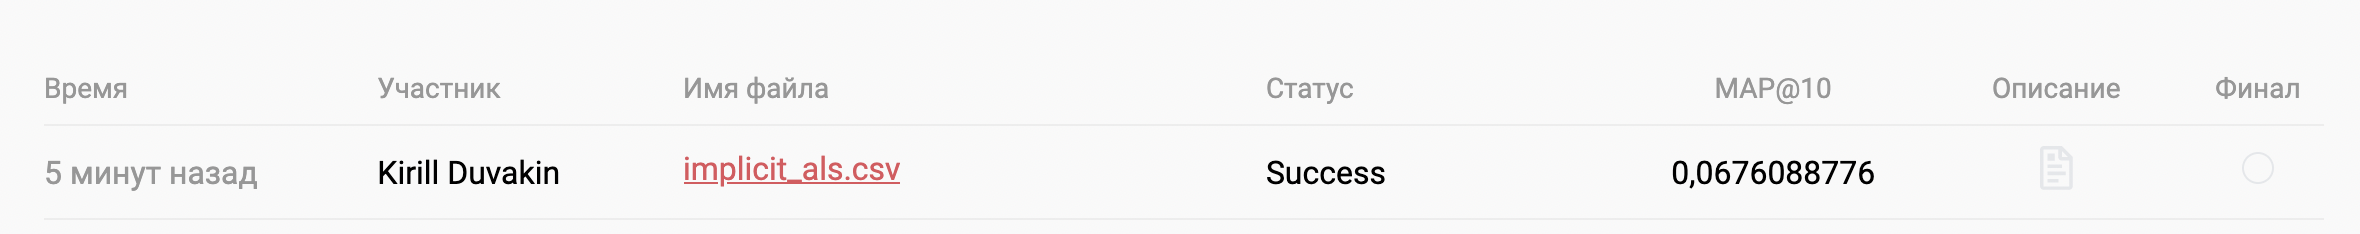